# CNN for brain skull stripping

## Description

When analyzing brain images it is usually needed to remove the skull: such operation is commonly known as **skull stripping**. 

In this task we want you to implement a Convolutional Neural Network (CNN) to solve this **segmentation** problem:  
Given an [axial slice](https://en.wikipedia.org/wiki/Anatomical_plane) of a brain, the CNN should produce an image in which each pixel value represents the (pseudo)probability that the pixel belongs to brain tissue. That way, given the probability map and a threshold we can create a brain mask that removes the skull when applied to the original image.

### Subtask 1

Implement the architecture of the CNN. It should have **at least 2 convolutional layers**, and you can add the type and amount of layers you deem convenient.

You have the option to either design your own architecture or use one from the literature. In this last case, please, cite the corresponding publication.

### Subtask 2

Cross-entropy loss and precision / recall metrics are provided so that you can train and assess your network right away. However, we want to evaluate the performance of the network using one of the most typical metrics in biomedical image segmentation: the **Sorensen-DICE coefficient**. 

Provide an implementation of the metric so that it can be assessed during training.

### Subtask 3

Train your network from scratch or fine tune pre-trained weights from other reference datasets (such as ImageNet) using the provided dataset. 

Provide the metrics reported in subtask 2 for the train and validation sets. You can use the batch data loader implemented in the notebook to load your data, but you are free to use your own implementation if you need to.

_NOTE: We do not expect you to achieve state-of-the-art performance, so use the minimum number of epochs / iterations so that you can evaluate if the network is learning or not._ 

### Subtask 4

###### **Justify the decisions** made regarding the **architecture** and the **training** process.
Considering those decisions, briefly **comment the results** obtained.

_NOTE: You can answer this question at the end of the notebook using the integrated Markdown interpreter._

## Requirements

- The choice of deep learning framework (if using any) is up to you. However, all the provided code is written in **TensorFlow**, so if you use another framework you'll have to port the implementation yourself.

- You can include external Python files to organize your functions and / or classes. Just be sure to attach them in the response so that we can run the code.

- The provided code was tested in **Python 3.6**, so you may have to change some things in order to make it work in other versions of Python.

## Provided code

### Python imports

In [2]:
import glob
import os
import time

import tensorflow as tf
import numpy as np
import skimage.io as skio
import skimage.transform as sktransform
import matplotlib.pyplot as plt
%matplotlib inline

### Loss function: Weighted cross-entropy

In [3]:
def weighted_nd_cross_entropy(logits, labels, weight_per_class=None):
    """
    Weighted cross-entropy loss for n-dimensional one-hot encoded logits and label tensors    
    """
    with tf.name_scope('weighted_cross_entropy'):
        # Transform logits and labels into 2-dimensional tensors to compute the cross entropy loss
        logits_shape = tf.shape(logits)
        labels_shape = tf.shape(logits)
        logits = tf.reshape(tensor=logits, shape=[-1, logits_shape[-1]])
        labels = tf.reshape(tensor=labels, shape=[-1, labels_shape[-1]])

        # Compute raw cross-entropy
        xent = tf.nn.softmax_cross_entropy_with_logits(
            logits=logits, 
            labels=labels, 
            name='raw_xe'
        )

        # Optional, Weight cross-entropy by class
        loss_name = "cross_entropy"
        if weight_per_class is not None:
            # Assertions
            weight_per_class = np.atleast_2d(weight_per_class)

            # Weights per label for class-balancing (shape: [1, batch_size])
            weight_per_label = tf.transpose( 
                tf.matmul(labels, tf.transpose(tf.constant(weight_per_class, dtype=tf.float32))) 
            )
            # Weighted cross-entropy (shape; [1, batch_size])
            xent = weight_per_label * xent    
            loss_name = "weighted_cross_entropy"

        return tf.reduce_mean(xent, name=loss_name)

### Metrics: Precision, recall and accuracy

In [4]:
def accuracy(prediction, ground_truth):
    """
    Computes the accuracy of the prediction wrt to the ground truth. 
    The dimensions of prediction and ground_truth must match.
    Prediction and ground-truth are expected to be one-hot encoded tensors. 
    """
    with tf.name_scope('accuracy'):
        correct_predictions = tf.equal(
            tf.argmax(input=prediction, axis=-1), 
            tf.argmax(input=ground_truth, axis=-1)
        )
        return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

In [5]:
def precision(prediction, ground_truth, category):
    """
    Compute precision for the specified category.
    The dimensions of prediction and ground_truth must match.
    Prediction and ground-truth are expected to be one-hot encoded tensors.
    """
    with tf.name_scope('precision'):
        # Compute the hard-decision from the softmax map
        hard_decision_pred = tf.cast(
            prediction / tf.reduce_max(prediction, axis=-1, keep_dims=True),
            dtype=tf.int32
        )
        hard_decision_gt = tf.cast(
            ground_truth / tf.reduce_max(ground_truth, axis=-1, keep_dims=True), 
            dtype=tf.int32
        )

        # For now assume that we only compute these metrics for images (shape: [batch_size, height, width, classes])
        prediction = hard_decision_pred[:, :, :, category]
        ground_truth = hard_decision_gt[:, :, :, category]

        intersection = prediction * ground_truth

        num_true_positives = tf.cast(tf.reduce_sum(intersection), dtype=tf.float32)
        num_predictions = tf.cast(tf.reduce_sum(prediction), dtype=tf.float32)

        precision = num_true_positives / (num_predictions + 1e-9)

        return precision, recall, dice

In [6]:
def recall(prediction, ground_truth, category):
    """
    Compute recall for the specified category.
    The dimensions of prediction and ground_truth must match.
    Prediction and ground-truth are expected to be one-hot encoded tensors.
    """
    with tf.name_scope('recall'):
        # Compute the hard-decision from the soft-decision
        hard_decision_pred = tf.cast(
            prediction / tf.reduce_max(prediction, axis=-1, keep_dims=True),
            dtype=tf.int32
        )
        hard_decision_gt = tf.cast(
            ground_truth / tf.reduce_max(ground_truth, axis=-1, keep_dims=True), 
            dtype=tf.int32
        )

        # For now assume that we only compute these metrics for images (shape: [batch_size, height, width, classes])
        prediction = hard_decision_pred[:, :, :, category]
        ground_truth = hard_decision_gt[:, :, :, category]

        intersection = prediction * ground_truth

        num_true_positives = tf.cast(tf.reduce_sum(intersection), dtype=tf.float32)
        num_true = tf.cast(tf.reduce_sum(ground_truth), dtype=tf.float32)

        precision = num_true_positives / (num_predictions + 1e-9)
        recall = num_true_positives / (num_true + 1e-9)

        return precision, recall, dice

### Data Ingestion: `DataLoader` class to generate batches of training / validation data

In [7]:
class DataLoader(object):
    
    GROUND_TRUTH_LABELS = 'gt'
    
    def __init__(self, data_path, batch_size=16, im_shape=None, return_names=False, seed=None):
        np.random.seed(seed)
        
        # Load all T1 and GT labels
        self.data_path = data_path
        labels = np.array(glob.glob(os.path.join(data_path, self.GROUND_TRUTH_LABELS, '*')))
        file_names = [os.path.basename(label) for label in labels]
        t1 = np.array([os.path.join(data_path, 't1', fname) for fname in file_names])
        
        # Shuffle all the data 
        self.n_samples = len(labels)
        perm_ind = np.random.permutation(self.n_samples)
        self.labels = labels[perm_ind]
        self.t1 = t1[perm_ind]
        
        # Initialize batch index
        self.batch_size = batch_size
        self.batch_index = 0
        
        # Image shape
        if im_shape is None:
            # Load a sample image and get the shape
            sample_image_path = t1[0]
            self.im_shape = skio.imread(sample_image_path, as_grey=True).shape
        else :
            self.im_shape = im_shape
        
        # Other attributes
        self.num_modalities = 1
        self.num_classes = 2
        self.return_names = return_names
        
    def get_all(self):
        """
        Returns all the images.
        """
        # Get batches and reset data loader
        batch_x, batch_y, fnames = self._next_batch(self.n_samples)
        self._reset()
        # Return batches and optionally names
        if self.return_names:
            return batch_x, batch_y, fnames
        else:
            return batch_x, batch_y
                
    def next(self):
        """
        Returns the next batch.
        """
        if self.batch_index < self.n_samples:
            # Compute current batch size
            if self.batch_index + self.batch_size <= self.n_samples:
                c_batch_size = self.batch_size
            else:
                c_batch_size = self.n_samples - self.batch_index
            
            # Load a batch of images and preprocess / augment them
            batch_x, batch_y, filenames = self._next_batch(c_batch_size)
            
            # Move batch index
            self.batch_index += c_batch_size
        
            if self.return_names:
                return batch_x, batch_y, filenames
            else:
                return batch_x, batch_y
        else:
            # Reset the generator
            self._reset()
            raise StopIteration
        
    def __iter__(self):
        return self
        
    def __next__(self):
        return self.next()       
    
    def _reset(self):
        self.batch_index = 0
        
        # Reshuffle data
        permute_ind = np.random.permutation(self.n_samples)
        self.labels = self.labels[permute_ind]
        self.t1 = self.t1[permute_ind]
        
    def _next_batch(self, current_batch_size):
        # Batches shape
        x_shape = (current_batch_size,) + self.im_shape + (self.num_modalities,)
        y_shape = (current_batch_size,) + self.im_shape + (self.num_classes,)
        
        # Pre-allocate numpy array
        batch_x = np.empty(x_shape, dtype=np.float32)
        batch_y = np.empty(y_shape, dtype=np.float32)
        
        # Load images
        t1 = self.t1[self.batch_index:self.batch_index + current_batch_size]
        gt = self.labels[self.batch_index:self.batch_index + current_batch_size]
        
        # Filenames
        fnames = [os.path.basename(im).split('.')[-2] for im in t1]
        
        for i, (t1_img, gt_img) in enumerate(zip(t1, gt)):
            t1_ndarray = skio.imread(fname=t1_img, as_grey=True)
            gt_ndarray = skio.imread(fname=gt_img, as_grey=True)
            
            # Resize to im_shape
            t1_ndarray = sktransform.resize(t1_ndarray, output_shape=self.im_shape, mode='reflect')
            gt_ndarray = sktransform.resize(gt_ndarray, output_shape=self.im_shape, mode='reflect')
                        
            # Create x batch
            batch_x[i, :, :, 0] = t1_ndarray
            
            # Create y batch
            batch_y[i, :, :, 0] = gt_ndarray == 0
            batch_y[i, :, :, 1] = gt_ndarray > 0            
            
        return batch_x, batch_y, fnames

        
        # Get batches and reset data loader
        batch_x, batch_y, fnames = self._next_batch(self.n_samples)
        self._reset()
        # Return batches and optionally names
        if self.return_names:
            return batch_x, batch_y, fnames
        else:
            return batch_x, batch_y

In [8]:
TRAIN_DATA = './train/'
VALIDATION_DATA = './validation/'

In [9]:
# Initialize data and validation generator
train_generator = DataLoader(data_path=TRAIN_DATA, batch_size=8, return_names=False)
val_generator = DataLoader(data_path=VALIDATION_DATA, batch_size=16, return_names=False)

In [10]:
print('Image shape: {}'.format(train_generator.im_shape))
print('Number of train samples: {}'.format(train_generator.n_samples))
print('Number of validation samples: {}'.format(val_generator.n_samples))

Image shape: (176, 256)
Number of train samples: 1040
Number of validation samples: 260


Load Data

In [11]:
training = DataLoader(data_path=TRAIN_DATA, batch_size=1)
train_imgs, train_label = training.get_all()
train_label = train_label.reshape(1040, 176*256, 2)

validation = DataLoader(data_path=VALIDATION_DATA, batch_size=1)
valid_imgs, valid_label = validation.get_all()
valid_label = valid_label.reshape(260, 176*256, 2)

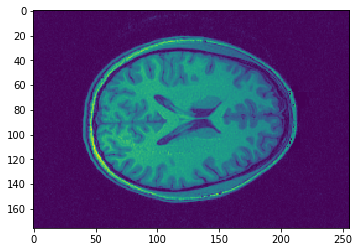

In [12]:
_ = plt.imshow(train_imgs[1, :, :, 0])

In [23]:
#_ = plt.imshow(train_label[1, :, :, 0])

In [ ]:
#_ = plt.imshow(train_label[1, :, :, 1])

## Solution

In [13]:
import json
from keras import backend as K
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, UpSampling2D

Using TensorFlow backend.


Subtask 1

In [14]:
from SimpleSegNet import model

Subtask 2

In [15]:
from metrics import dice_loss, dice_coef

Subtask 3

In [16]:
# Parameters
b_size = 8
nb_epoch = 10
smooth_default = 1.

In [21]:
segnet_basic = model((train_imgs.shape[1], train_imgs.shape[2], 1),
                      classes=2, kernel_size = 3)

segnet_basic.compile(loss="categorical_crossentropy",
                     optimizer='adadelta', metrics=[dice_coef])

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc',
                             verbose=1, save_best_only=True,
                             mode='max')
callbacks_list = [checkpoint]

history = segnet_basic.fit(train_imgs[::6, :, :, :], train_label[::6, :, :],
                           callbacks=callbacks_list,
                           batch_size=b_size, epochs=nb_epoch,
                           verbose=1,
                           validation_data=(valid_imgs[::2, :, :], valid_label[::2, :, :]),
                           shuffle=True) # validation_split=0.33
 
segnet_basic.save('SS_SegNet_Weights.hdf5')
segnet_basic.predict(train_imgs[0, :, :, :])

Train on 174 samples, validate on 130 samples
Epoch 1/1
174/174 [==============================] - 53674s 308s/step - loss: 0.1994 - dice_coef: 0.7891 - val_loss: 0.1131 - val_dice_coef: 0.8223


/home/chrbecker/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:432: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Subtask 4

I could not answer the questions in an adequate manner since I was lacking the computational resources. However, I decided to go for a simplified SegNet architecture with three pooling layers and three upsamplings. Another commonly used architecture in medical applications is the U-Net, but it is able to segment more detailed features and not necessary in the problem at hand.
<br>
A trade-off has to be made between the computational costs and risk of overfitting. However the best number of poolying layers is hard to find if one is unable to perform an exploration of the hyper-space.
<br>
As a final layer I implemented a Sigmoid function, since we only want to perform a semantic segmentation that can perform a binary classification between what is brain and what isn't.